# Synthetic Data Experiments

Test synthentic datasets constructed from points drawn from the following distributions:
- Uniform
- Gaussian
- Poisson
- Negative Binomial

In [128]:
import numpy as np
import anndata
import pandas as pd
import os
from src import preprocess, get_hg_reduction, reduce, scatterplot, knn_auto
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
import seaborn as sns
from sklearn.metrics import adjusted_rand_score as ARI
import umap

In [181]:
# Hyperparameters for data shape and resolutions to test
DATA_LOG = []
resolutions = [i/10 for i in range(5,21)]
n_genes = 500
n_cells = 1000

In [120]:
# Define how distribuions are constructed
class UniformDist(object):
    name = "Uniform"
    def sample(self, label_idx, size=None):
        return np.random.randint(50 * label_idx, 50 * (label_idx + 2), size=size)

class GaussianDist(object):
    name = "Gaussian"
    def sample(self, label_idx, size=None):
        return np.random.normal(label_idx, size=size)

class PoissonDist(object):
    name = "Poisson"
    def sample(self, label_idx, size=None):
        return np.random.poisson(5 + label_idx, size=size)
    
class NegativeBinomialDist(object):
    name = "Negative Binomial"
    def sample(self, label_idx, size=None):
        return np.random.negative_binomial(100 * (label_idx + 1), 0.7, size=size)

def build_sc_data(n_labels, dist, n_cells, n_genes, seed=888):
    np.random.seed(seed)
    
    # Build initial cell distribution
    # Cells all share the same distribution here
    label_data = [
        dist.sample(0, size=(n_cells // n_labels, n_genes))
        for _ in range(n_labels)
    ]
    
    # Differentiate each cell by selecting random number of genes
    # to inherit different distribution.
    for i in range(1, len(label_data)):
        c = label_data[i]
        n_rand = np.random.randint(1, n_genes)
        rand_idx = np.random.choice(np.arange(n_genes), size=n_rand, replace=True, p=None)
        c[:, rand_idx] = dist.sample(i, size=c[:, rand_idx].shape)

    ## Build final dataset
    data = np.concatenate(label_data)
    labels = np.concatenate([
        np.repeat(i, n_cells // n_labels)
        for i in range(n_labels)
    ])
    np.random.seed(None)
    
    return {
        'name': f'{dist.name} {n_labels} Cell Types',
        'data': data, 
        'labels': labels,
    }

In [121]:
DATASETS = []
seed_list = [888, 889, 890]
n_labels_list = [1, 3, 5, 10]
dist_list = [
    UniformDist(),
    GaussianDist(),
    PoissonDist(),
    NegativeBinomialDist(),
]


for dist in dist_list:
    for s in seed_list:
        for k in n_labels_list:
            DATASETS.append(build_sc_data(
                n_labels=k,
                dist=dist,
                n_cells=n_cells,
                n_genes=n_genes,
                seed=s
            ))

In [122]:
for d in DATASETS:

    name = d['name']
    dataset = d['data']
    labels = d['labels']
    
    # this is sparse
    reduced_adj = get_hg_reduction(dataset, n_clusters=4)
    print(f"Adjacency matrix has shape {reduced_adj.shape}")

    # Construct graph using reduced adj
    sources, targets = reduced_adj.nonzero()
    weights = np.array(reduced_adj[sources, targets])
    gg = ig.Graph(directed=False)
    gg.add_vertices(dataset.shape[0]) # cells
    gg.add_edges(list(zip(list(sources), list(targets))))

    # Construct graph with KNN
    sources_base, targets_base, weights_base = knn_auto(dataset)
    gg_base = ig.Graph(directed=False)
    gg_base.add_vertices(dataset.shape[0]) # cells
    gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))

    for i in range(5):
    
        for res_reduced in resolutions:

            ## Run Leiden - Reduced Adj
            part = la.find_partition(
                gg,
                la.RBConfigurationVertexPartition,
                weights=weights.flatten(),
                resolution_parameter=res_reduced,
            )
            predictions_reduced_hg = np.array(part.membership, dtype=int)
            score_reduced = ARI(predictions_reduced_hg, labels)

            DATA_LOG.append({
                'name': name,
                'score': score_reduced,
                'res': res_reduced,
                'method': 'hypergraph',
                'trial': i,
            })

        for res_base in resolutions:

            ## Run Leiden - KNN
            part_base = la.find_partition(
                gg_base,
                la.RBConfigurationVertexPartition,
                resolution_parameter=res_base,
            )
            predictions_base = np.array(part_base.membership, dtype=int)
            score_base = ARI(predictions_base, labels)

            DATA_LOG.append({
                'name': name,
                'score': score_base,
                'res': res_base,
                'method': 'knn',
                'trial': i,
            })

100%|███████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.74it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 26.20it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.12it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.33it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 22.78it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.29it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.40it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 26.18it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.12it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.38it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.74it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.05it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:32<00:00, 15.50it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.78it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.40it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 19.20it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.67it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 16.07it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.48it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.45it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:32<00:00, 15.48it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.89it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.88it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.36it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.00it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.18it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.95it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.86it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.90it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.77it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 35.13it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.97it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.62it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.26it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 36.94it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 31.09it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 34.04it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.97it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.92it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.96it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 37.73it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.01it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.79it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.17it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.89it/s]


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 36.84it/s]


Adjacency matrix has shape (999, 999)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.57it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


100%|███████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.60it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


In [124]:
len(DATA_LOG)

7680

In [123]:
df = pd.DataFrame(DATA_LOG)

In [127]:
df.groupby(['name', 'method']).std()

score       res     trial
name                            method                                  
Gaussian 1 Cell Types           hypergraph  0.464481  0.461941  1.417169
                                knn         0.391128  0.461941  1.417169
Gaussian 10 Cell Types          hypergraph  0.127852  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Gaussian 3 Cell Types           hypergraph  0.247063  0.461941  1.417169
                                knn         0.061094  0.461941  1.417169
Gaussian 5 Cell Types           hypergraph  0.141568  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Negative Binomial 1 Cell Types  hypergraph  0.464481  0.461941  1.417169
                                knn         0.391128  0.461941  1.417169
Negative Binomial 10 Cell Types hypergraph  0.050429  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Negative Binomial 3 Cell Types  hypergraph  0.172916  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Negative Binomial 5 Cell Types  hypergraph  0.032150  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Poisson 1 Cell Types            hypergraph  0.464481  0.461941  1.417169
                                knn         0.391128  0.461941  1.417169
Poisson 10 Cell Types           hypergraph  0.184628  0.461941  1.417169
                                knn         0.023192  0.461941  1.417169
Poisson 3 Cell Types            hypergraph  0.186641  0.461941  1.417169
                                knn         0.164530  0.461941  1.417169
Poisson 5 Cell Types            hypergraph  0.199674  0.461941  1.417169
                                knn         0.156999  0.461941  1.417169
Uniform 1 Cell Types            hypergraph  0.464481  0.461941  1.417169
                                knn         0.387748  0.461941  1.417169
Uniform 10 Cell Types           hypergraph  0.106110  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Uniform 3 Cell Types            hypergraph  0.331389  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169
Uniform 5 Cell Types            hypergraph  0.148013  0.461941  1.417169
                                knn         0.000000  0.461941  1.417169

In [126]:
df.groupby(['name', 'method']).mean()

score   res  trial
name                            method                           
Gaussian 1 Cell Types           hypergraph  0.312500  1.25    2.0
                                knn         0.187500  1.25    2.0
Gaussian 10 Cell Types          hypergraph  0.296976  1.25    2.0
                                knn         1.000000  1.25    2.0
Gaussian 3 Cell Types           hypergraph  0.361188  1.25    2.0
                                knn         0.981219  1.25    2.0
Gaussian 5 Cell Types           hypergraph  0.419569  1.25    2.0
                                knn         1.000000  1.25    2.0
Negative Binomial 1 Cell Types  hypergraph  0.312500  1.25    2.0
                                knn         0.187500  1.25    2.0
Negative Binomial 10 Cell Types hypergraph  0.509812  1.25    2.0
                                knn         1.000000  1.25    2.0
Negative Binomial 3 Cell Types  hypergraph  0.677629  1.25    2.0
                                knn         1.000000  1.25    2.0
Negative Binomial 5 Cell Types  hypergraph  0.772911  1.25    2.0
                                knn         1.000000  1.25    2.0
Poisson 1 Cell Types            hypergraph  0.312500  1.25    2.0
                                knn         0.187500  1.25    2.0
Poisson 10 Cell Types           hypergraph  0.301718  1.25    2.0
                                knn         0.893751  1.25    2.0
Poisson 3 Cell Types            hypergraph  0.094314  1.25    2.0
                                knn         0.642385  1.25    2.0
Poisson 5 Cell Types            hypergraph  0.273017  1.25    2.0
                                knn         0.726272  1.25    2.0
Uniform 1 Cell Types            hypergraph  0.312500  1.25    2.0
                                knn         0.183333  1.25    2.0
Uniform 10 Cell Types           hypergraph  0.486672  1.25    2.0
                                knn         1.000000  1.25    2.0
Uniform 3 Cell Types            hypergraph  0.637583  1.25    2.0
                                knn         1.000000  1.25    2.0
Uniform 5 Cell Types            hypergraph  0.639234  1.25    2.0
                                knn         1.000000  1.25    2.0

# Visualize Datasets

In [177]:
def test_dataset(name):
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(20,8)})
    
    d = [k for k in DATASETS if k['name'] == name][0]
    name = d['name']
    dataset = d['data']
    labels = d['labels']
    
    # this is sparse
    reduced_adj = get_hg_reduction(dataset, n_clusters=4)
    print(f"Adjacency matrix has shape {reduced_adj.shape}")

    # Construct graph using reduced adj
    sources, targets = reduced_adj.nonzero()
    weights = np.array(reduced_adj[sources, targets])
    gg = ig.Graph(directed=False)
    gg.add_vertices(dataset.shape[0]) # cells
    gg.add_edges(list(zip(list(sources), list(targets))))

    # Construct graph with KNN
    sources_base, targets_base, weights_base = knn_auto(dataset)
    gg_base = ig.Graph(directed=False)
    gg_base.add_vertices(dataset.shape[0]) # cells
    gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))
    
    part = la.find_partition(
        gg,
        la.RBConfigurationVertexPartition,
        weights=weights.flatten(),
        resolution_parameter=res_reduced,
    )
    predictions_reduced_hg = np.array(part.membership, dtype=int)
    score_reduced = ARI(predictions_reduced_hg, labels)
    
    part_base = la.find_partition(
        gg_base,
        la.RBConfigurationVertexPartition,
        resolution_parameter=res_base,
    )
    predictions_base = np.array(part_base.membership, dtype=int)
    score_base = ARI(predictions_base, labels)
    
    fig, axs = plt.subplots(1,3)
    
    embedding = umap.UMAP().fit_transform(d['data'])
    
    df = pd.DataFrame(embedding, columns=["UMAP 1", "UMAP 2"])
    df['Ground Truth'] = labels
    sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Ground Truth', data=df, ax=axs[1])
    axs[1].set_title("Ground Truth", fontsize=20)
    
    df['Hypergraph'] = predictions_reduced_hg
    sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='Hypergraph', data=df, ax=axs[2])
    axs[2].set_title(f"Hypergraph, ARI:{round(score_reduced, 3)}", fontsize=20)
    
    df['KNN'] = predictions_base
    sns.scatterplot(x='UMAP 1', y='UMAP 2', hue='KNN', data=df, ax=axs[0])
    axs[0].set_title(f"KNN, ARI:{round(score_base, 3)}", fontsize=20)
    
    fig.suptitle(name, fontsize=20)

100%|███████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.42it/s]


Adjacency matrix has shape (1000, 1000)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


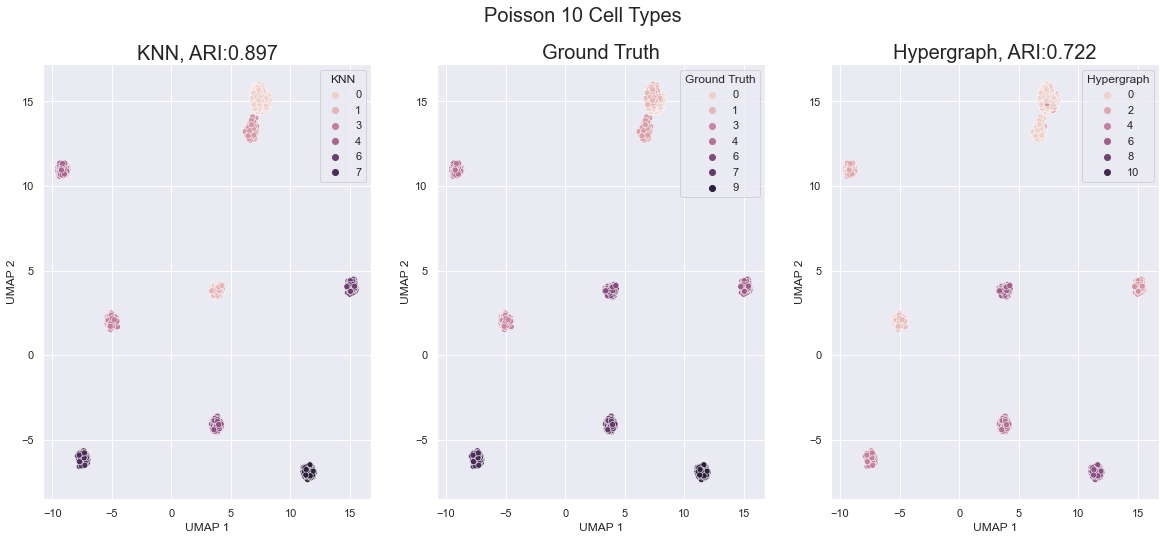

In [178]:
test_dataset('Poisson 10 Cell Types')

100%|███████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 45.26it/s]


Adjacency matrix has shape (1000, 1000)


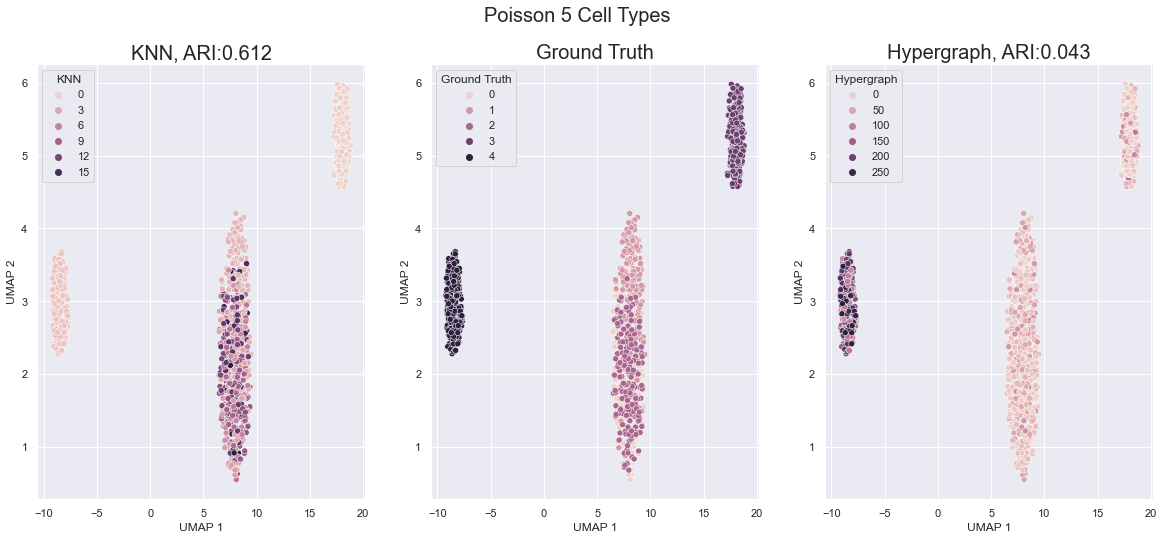

In [179]:
test_dataset('Poisson 5 Cell Types')

100%|███████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 18.78it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (1000, 1000)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


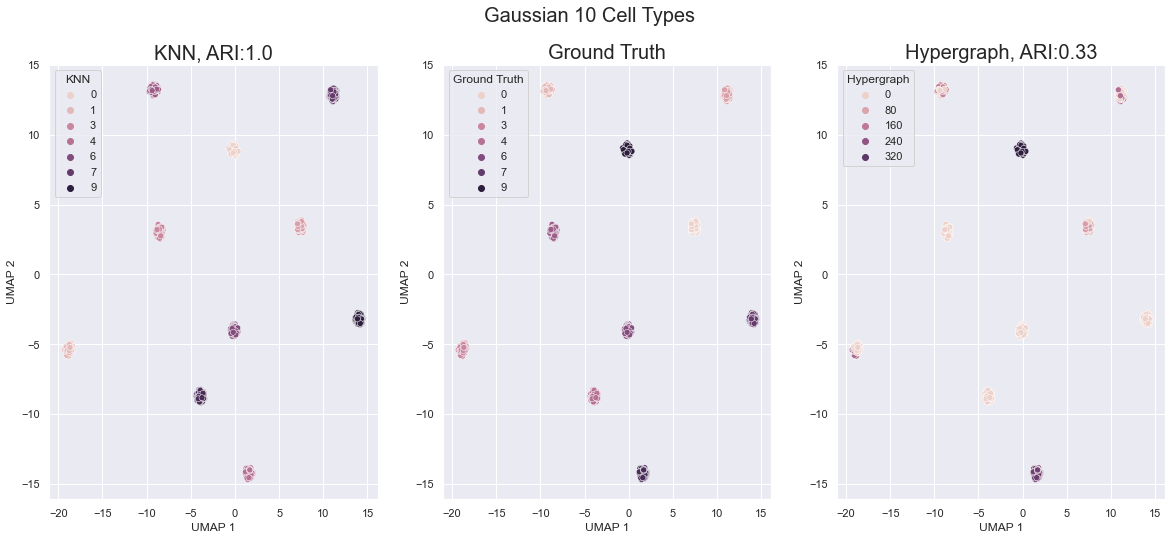

In [180]:
test_dataset('Gaussian 10 Cell Types')

We can see that in cases where hypergraph performs poorly, too many clusters are generated.